In [34]:
!pip install tensorflow==1.14.0
#!pip install -U keras


     |████████████████████████████████| 109.2MB 78kB/s 
     |████████████████████████████████| 3.2MB 35.4MB/s 
     |████████████████████████████████| 491kB 54.3MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [35]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics


import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

#tf.executing_eagerly()
print(tf.__version__)


2.2.0-rc2


In [0]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    expand = hparameters["expand"]
    channels = hparameters["channels"]
    depth_batch = channels // expand

    # Conv2D for 1 step of gradual update
    print('Forward prop : {}'.format(A_prev.shape))
    print('Filter Shape: {} '.format(W.shape))
    for i in range(depth_batch):
        # if you dont add b or not use a registered parameter, tensorflow will give error as follows:
        # Gradients do not exist for variables ['layer/Variable:0'] when minimizing the loss
        Z = tf.nn.conv2d(A_prev, W, [1, 1, 1, 1], "SAME") + b
        A_prev = tf.concat([A_prev[:, :, :, :i*expand ], Z, A_prev[:, :, :, i*expand + expand : ]], 3)
        print('Output Shape: {} '.format(Z.get_shape()))
        print('Input prop : {}'.format(A_prev.shape))
                                                
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return A_prev, cache

In [0]:
@tf.custom_gradient
def Gunn2D_3(A_prev, input_channels, expansion_rate, W, b):
    #def grad(dZ):
    #    print('backpropagation')
    #    dA, dW, db  = conv_backward(dZ, cache)
    #    return dA

    print('custom_gradient : {},  weights: '.format(A_prev.shape, weights))
    Z, cache = conv_forward(A_prev, W, b, hparameters)
    #Z = tf.cast(Z, 'float32')
    return Z, grad


class Gunn2D(layers.Layer):

  def __init__(self, input_channels, expansion_rate=32):
    super(Gunn2D, self).__init__()
    self.input_channels = input_channels
    self.expansion_rate = expansion_rate
    self.hparameters = {"pad" : 1, "stride": 1, "expand": self.expansion_rate, "channels": self.input_channels}

  def build(self, input_shape):
    print(input_shape)
    self.w = self.add_weight(shape=(3, 3, self.input_channels, self.expansion_rate), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(1, 1, 1, self.expansion_rate), initializer='random_normal', trainable=True)

  def call(self, inputs):
    #inputs = Conv2D(240, (1, 1), strides = (1, 1), padding='valid', name = 'zGunn')(inputs)
    #print(self.w, self.b)
    output, cache = conv_forward(inputs, self.w, self.b, self.hparameters)
    #self.w, self.b = cache[1], cache[2]
    print(self.w, self.b)
    #tf.print(self.w)
    #tf.print(self.b)
    print('output prop : {}'.format(output.shape))
    return output 


def GunnModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    print(input_shape)
    X_input = Input(input_shape)
    print('Before Gunn: {}'.format(X_input.get_shape()))
    Gunn2D_layer = Gunn2D(6, 2)  # At instantiation, we don't know on what inputs this is going to get called
    X = Gunn2D_layer(X_input)  # The layer's weights are created dynamically the first time the layer is called
    print('After Gunn: {}'.format(X.get_shape()))
    #print(Gunn2D_layer.kernel, Gunn2D_layer.bias)

    X = Flatten()(X)
    X = Dense(3, activation='softmax', name = 'fc1')(X)

    model = Model(inputs = X_input, outputs = X, name = 'GunnModel')
    
    return model

In [63]:
#print(tf.__version__)

#x = tf.ones((1, 32, 32, 240))
#Gunn2D_layer = Gunn2D(240, 32)  # At instantiation, we don't know on what inputs this is going to get called
X_train = tf.ones((50, 5, 5, 6))
X_test = tf.ones((20, 5, 5, 6))
Y_train = tf.ones((50, 3))
Y_test = tf.ones((20, 3))

gunnModel = GunnModel(X_train.shape[1:])
#sess.run(tf.global_variables_initializer()) # initialize 
#print(sess.run([gunnModel.output], feed_dict={Z: X_train}))
gunnModel.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
gunnModel.fit(x = X_train , y = Y_train, epochs = 5, steps_per_epoch = (X_train.shape[0]//10))
#gunnModel.fit(x = X_train , y = Y_train, epochs = 2, batch_size = 10, steps_per_epoch = (X_train.shape[0]//10))
#print(sess.run([gunnModel.output], feed_dict={Z: X_test}))
preds = gunnModel.evaluate(x=X_test, y=Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))



(5, 5, 6)
Before Gunn: (None, 5, 5, 6)
(None, 5, 5, 6)
Forward prop : (None, 5, 5, 6)
Filter Shape: (3, 3, 6, 2) 
Output Shape: (None, 5, 5, 2) 
Input prop : (None, 5, 5, 6)
Output Shape: (None, 5, 5, 2) 
Input prop : (None, 5, 5, 6)
Output Shape: (None, 5, 5, 2) 
Input prop : (None, 5, 5, 6)
<tf.Variable 'gunn2d_10/Variable:0' shape=(3, 3, 6, 2) dtype=float32> <tf.Variable 'gunn2d_10/Variable:0' shape=(1, 1, 1, 2) dtype=float32>
output prop : (None, 5, 5, 6)
After Gunn: (None, 5, 5, 6)
Epoch 1/5
Forward prop : (10, 5, 5, 6)
Filter Shape: (3, 3, 6, 2) 
Output Shape: (10, 5, 5, 2) 
Input prop : (10, 5, 5, 6)
Output Shape: (10, 5, 5, 2) 
Input prop : (10, 5, 5, 6)
Output Shape: (10, 5, 5, 2) 
Input prop : (10, 5, 5, 6)
<tf.Variable 'gunn2d_10/Variable:0' shape=(3, 3, 6, 2) dtype=float32> <tf.Variable 'gunn2d_10/Variable:0' shape=(1, 1, 1, 2) dtype=float32>
output prop : (10, 5, 5, 6)
Forward prop : (10, 5, 5, 6)
Filter Shape: (3, 3, 6, 2) 
Output Shape: (10, 5, 5, 2) 
Input prop : (10, 5

# Putting the GUNN layer it together

In [65]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics


import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)


def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    expand = hparameters["expand"]
    channels = hparameters["channels"]
    depth_batch = channels // expand

    # Conv2D for 1 step of gradual update
    for i in range(depth_batch):
        # if you dont add b or not use a registered parameter, tensorflow will give error as follows:
        # Gradients do not exist for variables ['layer/Variable:0'] when minimizing the loss
        Z = tf.nn.conv2d(A_prev, W, [1, 1, 1, 1], "SAME") + b
        A_prev = tf.concat([A_prev[:, :, :, :i*expand ], Z, A_prev[:, :, :, i*expand + expand : ]], 3)
                                                
    return A_prev


class Gunn2D(layers.Layer):

  def __init__(self, input_channels, expansion_rate=32):
    super(Gunn2D, self).__init__()
    self.input_channels = input_channels
    self.expansion_rate = expansion_rate
    self.hparameters = {"expand": self.expansion_rate, "channels": self.input_channels}

  def build(self, input_shape):
    self.w = self.add_weight(shape=(3, 3, self.input_channels, self.expansion_rate), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(1, 1, 1, self.expansion_rate), initializer='random_normal', trainable=True)

  def call(self, inputs):
    output = conv_forward(inputs, self.w, self.b, self.hparameters)
    return output 


def GunnModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)
    Gunn2D_layer = Gunn2D(6, 2)  # At instantiation, we don't know on what inputs this is going to get called
    X = Gunn2D_layer(X_input)  # The layer's weights are created dynamically the first time the layer is called

    X = Flatten()(X)
    X = Dense(3, activation='softmax', name = 'fc1')(X)

    model = Model(inputs = X_input, outputs = X, name = 'GunnModel')
    
    return model

2.2.0-rc2


In [66]:
X_train = tf.ones((50, 5, 5, 6))
X_test = tf.ones((20, 5, 5, 6))
Y_train = tf.ones((50, 3))
Y_test = tf.ones((20, 3))

gunnModel = GunnModel(X_train.shape[1:])
gunnModel.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
gunnModel.fit(x = X_train , y = Y_train, epochs = 5, steps_per_epoch = (X_train.shape[0]//10))
preds = gunnModel.evaluate(x=X_test, y=Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Epoch 1/5
5/5 [==============================] - 0s 3ms/step - loss: 3.3093 - categorical_accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 0s 2ms/step - loss: 3.3327 - categorical_accuracy: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 0s 2ms/step - loss: 3.3868 - categorical_accuracy: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 0s 2ms/step - loss: 3.4880 - categorical_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 3.7450 - categorical_accuracy: 0.0000e+00

Loss = 3.7450389862060547
Test Accuracy = 0.0


In [67]:
gunnModel.summary()


Model: "GunnModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 5, 6)]         0         
_________________________________________________________________
gunn2d (Gunn2D)              (None, 5, 5, 6)           110       
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 3)                 453       
Total params: 563
Trainable params: 563
Non-trainable params: 0
_________________________________________________________________


ERROR! Session/line number was not unique in database. History logging moved to new session 59


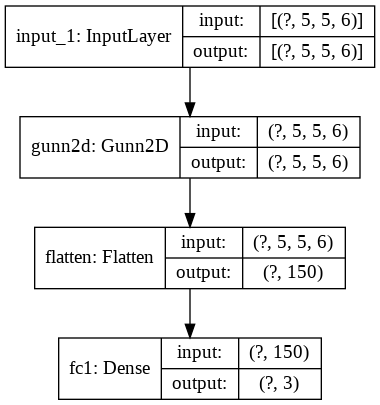

In [71]:
tf.keras.utils.plot_model(gunnModel, 'gunnModel_model.png', show_shapes=True)


# Backup without GUNN implementation


In [0]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    #paddings = tf.constant([[1, 0,],[2, pad,], [3, pad], [4, 0]])
    paddings = tf.constant([[0, 0], [pad, pad], [pad, pad], [0, 0]])
    X_pad = tf.pad(X, paddings, 'CONSTANT')
    
    return X_pad

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice and W. Do not add the bias yet.
    
    #print('a_slice_prev: {} '.format(a_slice_prev.shape))
    #print('W: {} '.format(W.shape))
    s = tf.multiply(a_slice_prev, W)   # element wise product in python
    # Sum over all entries of the volume s.
    Z = tf.math.reduce_sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z =  Z + b

    return Z


def conv_forward_back(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    m = 1
    print('Forward prop : {}'.format(A_prev.shape))
    
    # Retrieve dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    expand = hparameters["expand"]
    
    # Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int((n_H_prev + 2*pad -f) // stride ) + 1
    n_W = int((n_W_prev + 2*pad -f) // stride ) + 1
    
    print('Input Shape: {} {} {} {} '.format(m, n_H_prev, n_W_prev, n_C_prev, ))
    print('Filter Shape: {} {} {} {} '.format(f, f, n_C_prev, n_C))
    print('output Shape: {} {} {} {} '.format(n_H, n_W, stride, pad))
    # Initialize the output volume Z with zeros. 
    #Z = np.zeros(( m, n_H, n_W, n_C ))
    #Z = tf.zeros(( m, n_H, n_W, n_C ), tf.float32)
    
    Z = tf.compat.v1.placeholder(tf.float32, shape=(m, n_H, n_W, n_C))

    ####Z = tf.Variable(tf.zeros(( m, n_H, n_W, n_C ), tf.float32), validate_shape=False)
    #Z = tf.Variable(initial_value=tf.zeros(( m, n_H, n_W, n_C ), shape=( m, n_H, n_W, n_C ), validate_shape=False, dtype=tf.float32)
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    print('Input Shape after pad: {} '.format(A_prev_pad.shape))
    print('tf.shape(Z): {} '.format(tf.shape(Z)))

    for i in range(m):                               # loop over the batch of training examples
        #print(A_prev_pad.shape)
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        print(a_prev_pad.shape)
        for h in range(n_H):                           # loop over vertical axis of the output volume    
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    #print(m, h, w, c)
                    # Find the corners of the current "slice" 
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[ vert_start:vert_end, horiz_start:horiz_end, : ]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    #Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    scalar = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    Z[i, h, w, c].assign(scalar)
                    

                                            
    # Making sure your output shape is correct
    print(tf.shape(Z))
    print(m, n_H, n_W, n_C)
    #assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


In [0]:
from tensorflow.keras import layers


class Gunn2D_bk(layers.Layer):

  def __init__(self, input_channels, expansion_rate=32):
    super(Gunn2D, self).__init__()
    self.input_channels = input_channels
    self.expansion_rate = expansion_rate
    self.hparameters = {"pad" : 0, "stride": 1}

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.input_channels), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.input_channels,), initializer='random_normal', trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


print(tf.__version__)

#x = tf.ones((1, 32, 32, 240))
#Gunn2D_layer = Gunn2D(240, 32)  # At instantiation, we don't know on what inputs this is going to get called
x = tf.ones((1, 5, 5, 6))
Gunn2D_layer = Gunn2D(6, 2)  # At instantiation, we don't know on what inputs this is going to get called
y = Gunn2D_layer(x)  # The layer's weights are created dynamically the first time the layer is called
print(y)



1.14.0
(1, 5, 5, 6)
Forward prop : (1, 5, 5, 6)
Filter Shape: (3, 3, 6, 2) 
Output Shape: (1, 5, 5, 2) 
Input prop : (1, 5, 5, 6)
Output Shape: (1, 5, 5, 2) 
Input prop : (1, 5, 5, 6)
Tensor("gunn2d_13/Conv2D_1:0", shape=(1, 5, 5, 2), dtype=float32)


In [0]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    #paddings = tf.constant([[1, 0,],[2, pad,], [3, pad], [4, 0]])
    paddings = tf.constant([[0, 0], [pad, pad], [pad, pad], [0, 0]])
    X_pad = tf.pad(X, paddings, 'CONSTANT')
    
    return X_pad

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice and W. Do not add the bias yet.
    
    #print('a_slice_prev: {} '.format(a_slice_prev.shape))
    #print('W: {} '.format(W.shape))
    s = tf.multiply(a_slice_prev, W)   # element wise product in python
    # Sum over all entries of the volume s.
    Z = tf.math.reduce_sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z =  Z + float(b)

    return Z


def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    print('Forward prop : {}'.format(A_prev.shape))
    
    # Retrieve dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int((n_H_prev + 2*pad -f) // stride ) + 1
    n_W = int((n_W_prev + 2*pad -f) // stride ) + 1
    
    print('Input Shape: {} {} {} {} '.format(m, n_H_prev, n_W_prev, n_C_prev, ))
    print('Filter Shape: {} {} {} {} '.format(f, f, n_C_prev, n_C))
    print('output Shape: {} {} {} {} '.format(n_H, n_W, stride, pad))
    # Initialize the output volume Z with zeros. 
    #Z = np.zeros(( m, n_H, n_W, n_C ))
    #Z = tf.zeros(( m, n_H, n_W, n_C ), tf.float32)
    Z = tf.Variable(tf.zeros(( m, n_H, n_W, n_C ), tf.float32), validate_shape=False)
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    print('Input Shape after pad: {} '.format(A_prev_pad.shape))

    for i in range(m):                               # loop over the batch of training examples
        #print(A_prev_pad.shape)
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        print(a_prev_pad.shape)
        for h in range(n_H):                           # loop over vertical axis of the output volume    
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    #print(m, h, w, c)
                    # Find the corners of the current "slice" 
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[ vert_start:vert_end, horiz_start:horiz_end, : ]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    #Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    scalar = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    Z[i, h, w, c].assign(scalar)
                    

                                            
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


In [0]:

import tensorflow as tf
import numpy as np
import keras.backend as K
from tqdm import tqdm
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense

# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Dataset: given 2 numbers, predict the sum
# Sum 2 numbers from 0 to 10 dataset
samples = np.random.randint(0, 9, size=(100,2))
targets = np.sum(samples, axis=-1)

# Samples for testing
samples_test = np.random.randint(0, 9, size=(10,2))
targets_test = np.sum(samples_test, axis=-1)

# Model
x = Input(shape=[2])
y = Dense(units=1)(x)
model = Model(x, y)

# Loss
def loss_fn(y_true, y_pred):
    # You can get all the crazy and twisted you 
    # want here no Keras restrictions this time :)
    loss_value = K.sum(K.pow((y_true - y_pred), 2))
    return loss_value

# Optimizer to run the gradients
optimizer = Adam(lr=1e-4)

# Graph creation
# Creating training flow
# Ground truth input, samples or X_t
y_true = Input(shape=[0])

# Prediction
y_pred = model(x)

# Loss 
loss = loss_fn(y_true, y_pred)

# Operation for getting 
# gradients and updating weights
updates_op = optimizer.get_updates(
    params=model.trainable_weights, 
    loss=loss)

# The graph is created, now we need to call it
# this would be similar to tf session.run()
train = K.function(
    inputs=[x, y_true], 
    outputs=[loss], 
    updates=updates_op)

test = K.function(
    inputs=[x, y_true], 
    outputs=[loss])


# Training loop
epochs = 100

for epoch in range(epochs):
    print('Epoch %s:' % epoch)

    # Fancy progress bar
    pbar = tqdm(range(len(samples)))

    # Storing losses for computing mean
    losses_train = []

    # Batch loop: batch size=1
    for idx in pbar:
        sample = samples[idx]
        target = targets[idx]

        # Adding batch dim since batch=1
        sample = np.expand_dims(sample, axis=0)
        target = np.expand_dims(target, axis=0)

        # To tensors, input of 
        # K.function must be tensors
        sample = K.constant(sample)
        target = K.constant(target)

        # Running the train graph
        loss_train = train([sample, target])
        
        # Compute loss mean
        losses_train.append(loss_train[0])
        loss_train_mean = np.mean(losses_train)
        
        # Update progress bar
        pbar.set_description('Train Loss: %.3f' % loss_train_mean)

    # Testing
    losses_test = []
    for idx in range(len(samples_test)):
        sample_test = samples_test[idx]
        target_test = targets_test[idx]

        # Adding batch dim since batch=1
        sample_test = np.expand_dims(sample_test, axis=0)
        target_test = np.expand_dims(target_test, axis=0)

        # To tensors
        sample_test = K.constant(sample_test)
        target_test = K.constant(target_test)
        
        # Evaluation test graph
        loss_test = test([sample_test, target_test])
        
        # Compute test loss mean
        losses_test.append(loss_test[0])
    
    loss_test_mean = np.mean(losses_test)
    print('Test Loss: %.3f' % loss_test_mean)


AttributeError: ignored

In [0]:
@tf.custom_gradient
def custom_op(x):
    result = ... # do forward computation
    def custom_grad(dy):
        grad = ... # compute gradient
        return grad
    return result, custom_grad

NameError: ignored

In [0]:
First of all, the "unification" of the APIs (as you call it) under keras doesn't prevent you from doing things like you did in TensorFlow 1.x. Sessions might be gone but you can still define your model like any python function and train it eagerly without keras (i.e. through tf.GradientTape)

Now, if you want to build a keras model with a custom layer that performs a custom operation and has a custom gradient, you should do the following:

a) Write a function that performs your custom operation and define your custom gradient. More info on how to do this here.

@tf.custom_gradient
def custom_op(x):
    result = ... # do forward computation
    def custom_grad(dy):
        grad = ... # compute gradient
        return grad
    return result, custom_grad
Note that in the function you should treat x and dy as Tensors and not numpy arrays (i.e. perform tensor operations)

b) Create a custom keras layer that performs your custom_op. For this example I'll assume that your layer doesn't have any trainable parameters or change the shape of its input, but it doesn't make much difference if it does. For that you can refer to the guide that you posted check this one.

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomLayer, self).__init__()

    def call(self, x):
        return custom_op(x)  # you don't need to explicitly define the custom gradient
                             # as long as you registered it with the previous method
Now you can use this layer in a keras model and it will work. For example:

inp = tf.keras.layers.Input(input_shape)
conv = tf.keras.layers.Conv2D(...)(inp)  # add params like the number of filters
cust = CustomLayer()(conv)  # no parameters in custom layer
flat = tf.keras.layers.Flatten()(cust)
fc = tf.keras.layers.Dense(num_classes)(flat)

model = tf.keras.models.Model(inputs=[inp], outputs=[fc])
model.compile(loss=..., optimizer=...)  # add loss function and optimizer
model.fit(...)  # fit the model

# Stack overflow

In [0]:
I am trying to do CIFAR-10 Image Classification using GUNN-15 model based on paper : https://arxiv.org/pdf/1711.09280.pdf


I've built GUNN-15 Model in Keras for 10 classes as follows:

```
def GUNN_15_model(input_shape):
    """
    Implementation of the GUNN-15 Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'z1')(X_input) # 32x32x3 -> 32x32x64   ; padding = 1
    X = BatchNormalization(axis = 3 , name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Conv2D(240, (1, 1), strides = (1, 1), padding='valid', name = 'z2')(X) # 32x32x64 -> 32x32x240
    X = BatchNormalization(axis = 3 , name = 'bn2')(X)
    layer = Activation('relu')
    X = layer(X)
    print(X)
    X = Lambda(lambda x: Gunn2D(X, 240, 20, layer.get_weights()))(X)
    #X = Lambda(Gunn2D(X, 240, 20))(X)
    print(X)
    X = Conv2D(300, (1, 1), strides = (1, 1), padding='valid', name = 'z3')(X)
    X = BatchNormalization(axis = 3 , name = 'bn3')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((2, 2), name = 'avg_pool1')(X)
    print(X)
    X = Lambda(lambda x: Gunn2D(X, 300, 25))(X)
    print(X)
    X = Conv2D(360, (1, 1), strides = (1, 1), padding='valid', name = 'z4')(X)
    X = BatchNormalization(axis = 3 , name = 'bn3')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((2, 2), name = 'avg_pool2')(X)
    print(X)
    X = Lambda(lambda x: Gunn2D(X, 360, 30))(X)
    print(X)
    X = Conv2D(360, (1, 1), strides = (1, 1), padding='valid', name = 'z5')(X)
    X = BatchNormalization(axis = 3 , name = 'bn3')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((8, 8), name = 'avg_pool3')(X)
    X = Flatten()(X)
    X = Dense(360, activation='softmax', name = 'fc1')(X)
    X = Dense(360, activation='softmax', name = 'fc2')(X)
    X = Dense(10, activation='softmax', name = 'fc3')(X)

    model = Model(inputs = X_input, outputs = X, name = 'GUNN-15-Model')
    print(model)
    return model

```

The Gunn2D() layers have been inserted at the required positions in the model. These Gunn2D() layers are my custom layers that would take the input as X (input tensor) and filter/weights and output tensor during forward pass, while in backward pass it is supposed to calculate the derivatives of weights and input layers and then update weights and input layers using the output tensor. 


I have function conv_forward() that does the forward pass for a CNN.

```
def conv_forward(A_prev, W, b, hparameters):
    ...
    cache = (A_prev, W, b, hparameters)
    return Z, cache

```



```
def conv_backward(dZ, cache):
    ...
    return dA_prev, dW, db

```


The entire function for the above definitions is as below:

```
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = a_slice_prev * W   # element wise product in python
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z =  Z + float(b)

    return Z


def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    print('Forward prop : {}'.format(A_prev.shape))
    
    # Retrieve dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int((n_H_prev + 2*pad -f) // stride ) + 1
    n_W = int((n_W_prev + 2*pad -f) // stride ) + 1
    
    print('Input Shape: {} {} {} {} '.format(m, n_H_prev, n_W_prev, n_C_prev, ))
    print('Filter Shape: {} {} {} {} '.format(f, f, n_C_prev, n_C))
    print('output Shape: {} {} {} {} '.format(n_H, n_W, stride, pad))
    # Initialize the output volume Z with zeros. 
    #Z = np.zeros(( m, n_H, n_W, n_C ))
    #Z = tf.zeros(( m, n_H, n_W, n_C ), tf.float32)
    Z = tf.Variable(tf.zeros(( m, n_H, n_W, n_C ), tf.float32), validate_shape=False)
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)

    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume    
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" 
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[ vert_start:vert_end, horiz_start:horiz_end, : ]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])

                                            
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache




def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i, :]
        da_prev_pad = dA_prev_pad[i, :]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters 
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad : use X[pad:-pad, pad:-pad, :]
        dA_prev[i, :, :, :] = dA_prev_pad[i, pad:-pad, pad:-pad, :]
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db
```



I want to write get the Gunn2D layer call conv_forward() during forward pass and conv_backward() during backward pass while also updating the weights of layer and modifying output tensor during forward pass and backward pass.

i have trued to use Lambda function of Keras in the model where I call this function :

```
@tf.custom_gradient
def Gunn2D(A_prev, input_channels, expansion_rate, weights):
    def grad(dZ):
        print('backpropagation')
        dA, dW, db  = conv_backward(dZ, cache)
        return dA

    print('custom_gradient : {},  weights: '.format(A_prev.shape, weights))
    Z, cache = conv_forward(A_prev, W, b, hparameters)
    Z = tf.cast(Z, 'float32')
    return Z, grad
```

and Create the model using:

```
# Create model
gunn15model = GUNN_15_model(X_train.shape[1:]) # input: (32, 32, 3)
```

This gives me the error:

```
Tensor("activation_6/Relu:0", shape=(?, 32, 32, 240), dtype=float32)
custom_gradient : (?, 32, 32, 240),  weights: 
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-16-12c4818aacca> in <module>()
----> 1 gunn15model = GUNN_15_model(X_train.shape[1:]) # input: (32, 32, 3)
      2 

6 frames
<ipython-input-15-35d163565c64> in Gunn2D(A_prev, input_channels, expansion_rate, weights)
      7 
      8     print('custom_gradient : {},  weights: '.format(A_prev.shape, weights))
----> 9     Z, cache = conv_forward(A_prev, W, b, hparameters)
     10     Z = tf.cast(Z, 'float32')
     11     return Z, grad

NameError: name 'W' is not defined
```



The layer.get_weights() seems to be not passing any value